# Merging data from headlines dataset to odds and game score dataset


In [ ]:
# install.packages('readxl')
library(readxl)
library(dplyr)
library(lubridate)


#load first odds/game dataset
df4 <- read_excel('/content/nfl (1).xlsx')

#load second odds/game dataset
df3 <-read.csv('/content/NFL_Odds_Data_2017-2022.csv')

df2 <-read.csv('/content/df_scored_9.csv')

head(df2)

#select columns of interest
selected_columns <- c("Date", "Home Team", "Away Team", "Home Odds Close", "Home Odds Open", "Away Odds Open", "Away Odds Close", "Home Score", "Away Score")
df4 <- df4[, selected_columns]

#rename
names(df4) <- c("Date", "Home_Team", "Away_Team", "Home_Odds_Close", "Home_Odds_Open", "Away_Odds_Open", "Away_Odds_Close", "Home_Score", "Away_Score")


#set date range
start_date <- as.Date("2017-09-01")
end_date <- as.Date("2022-02-20")

#edit df4 to fit date range
df4 <- df4[df4$Date >= start_date & df4$Date <= end_date, ]

#convert to date format
df3$Date <- as.POSIXct(df3$Date, format = "%Y-%m-%d")



# merge odds data sets


In [ ]:
# dictionary to standardize team names

nfl_teams <- c(
  "Arizona Cardinals" = c("Cardinals", "Arizona", "Redbirds", "arizona", "Cards", "AZ", "ARI", "Cardinal"),
  "Atlanta Falcons" = c("Falcons", "Atlanta", "Falcs", " ATL", "Dirty Birds", "Falcon"),
  "Baltimore Ravens" = c("Ravens", "Baltimore", "BAL", "Flock", "Raven"),
  "Buffalo Bills" = c("Bills", "Buffalo", "Mafia", "BUF", "BUFFS", "Bill"),
  "Carolina Panthers" = c("Panthers", "Carolina", "Cats", "CAR", "Panthers"),
  "Chicago Bears" = c("Bears", "Chicago", "CHI", "Bear", "Midway"),
  "Cincinnati Bengals" = c("Bengals", "Cincinnati", "Bungles", "Bengal", "Stripes", "Tiger"),
  "Cleveland Browns" = c("Browns", "Cleveland", "Brown", "Dawgs", "Dawg", "CLE"),
  "Dallas Cowboys" = c("Cowboys", "Dallas", "DAL", "America's Team", "Dem Boy"),
  "Denver Broncos" = c("Broncos", "Denver", "Orange Crush", "DEN"),
  "Detroit Lions" = c("Lions", "Detroit", "Motor City", "Kitties", "DET"),
  "Green Bay Packers" = c("Packers", "Green Bay", "GB", "Pack", "Cheeseheads", "Cheese Heads", "Packer","GreenBay"),
  "Houston Texans" = c("Texans", "Houston", "Hou", "H-Town", "Texan"),
  "Indianapolis Colts" = c("Colts", "Indianapolis", "IND", "Colt"),
  "Jacksonville Jaguars" = c("Jaguars", "Jacksonville", "JAX", "Jags", "Jaguar", "Jag"),
  "Kansas City Chiefs" = c("Chiefs", "Kansas City", "KC", "Chief", "Kansas","KansasCity","KCChiefs"),
  "Los Angeles Chargers" = c("Chargers", "LA Chargers", "Charger", "LAC", "SD", "San Diego", "Bolts","LAChargers"),
  "Las Vegas Raiders" = c("Raiders", "Las Vegas", "LV", "Oakland", "OAK", "Silver and Black", "Raider","LasVegas","LVRaiders"),
  "Los Angeles Rams" = c("Rams", "LA Rams", "LAR", "St. Louis", "STL", "LAR", "Saint Louis", "Ram","LARams"),
  "Miami Dolphins" = c("Dolphins", "Miami", "MIA", "Dolphin", "Fins"),
  "Minnesota Vikings" = c("Vikings", "Minnesota", "Purple", "MIN", "Vikes", "Viking"),
  "New England Patriots" = c("Patriots", "New England", "Pats", "NE", "Patriot", "NewEngland"),
  "New Orleans Saints" = c("Saints", "New Orleans", "NO", "Saint","NewOrleans"),
  "New York Giants" = c("Giants", "NY Giants", "NYG", "Giant", "G-Men","NYGiants"),
  "New York Jets" = c("Jets", "NY Jets", "NYJ", "Jet", "NYJets"),
  "Philadelphia Eagles" = c("Eagles", "Philadelphia", "Philly", "Birds", "PHI", "Eagle"),
  "Pittsburgh Steelers" = c("Steelers", "Pittsburgh", "PIT", "Black and Gold", "Steeler"),
  "San Francisco 49ers" = c("49ers", "San Francisco", "9ers", "Niners", "SF", "Niner","SanFrancisco"),
  "Seattle Seahawks" = c("Seahawks", "Seattle", "Legion of Boom", "SEA", "Seahawk"),
  "Tampa Bay Buccaneers" = c("Buccaneers", "Tampa Bay", "TB", "Bucs", "Tampa", "Buccaneer","TampaBay"),
  "Tennessee Titans" = c("Titans", "Tennessee", "Music City", "Titan", "TEN"),
  "Washington Football Team" = c("Washington", "Football Team", "Redskins", "Skins", "Washington Football Team", "WFT", "Commanders", "Commies","Washingtom")
)


# Function to replace team names
replace_team <- function(team_name) {
  for (team in names(nfl_teams)) {
    if (team_name %in% nfl_teams[[team]]) {
      return(team)
    }
  }
  return(team_name)  # Return original name if no match found
}





In [ ]:
# Apply the function to the "Home" column of df3
df3$Visitor <- sapply(df3$Visitor, replace_team)

# Output the modified dataframe
head(df3)

In [ ]:
remove_numbers <- function(team_name) {
  # Use regular expression to remove numbers at the end of the team names
  clean_name <- gsub("\\d+$", "", team_name)
  return(clean_name)
}

df3$Visitor <-remove_numbers(df3$Visitor)
df3$Date <- as.POSIXct(df3$Date, format = "%Y-%m-%d")
head(df3)

In [ ]:
#check to make sure the 32 teams are present only under one name each

unique_home_values <- unique(df3$Visitor)
print(unique_home_values)



In [ ]:
#merge the dataframes
merged_df <- merge(df3, df4, by.x = c("Date", "Home", "Visitor"), by.y = c("Date", "Home_Team", "Away_Team"))

head(merged_df)

In [ ]:
#standardize ml odds to one format (decimal)

american_to_decimal <- function(moneyline) {
  decimal_odds <- ifelse(moneyline > 0, (moneyline / 100) + 1, (100 / abs(moneyline)) + 1)
  return(decimal_odds)
}
temp_scores <- merged_df$Moneyline_away

merged_df$Moneyline_away <- merged_df$Moneyline_home
merged_df$Moneyline_home <- temp_scores


merged_df$Decimal_Odds_Away <- american_to_decimal(merged_df$Moneyline_away)
merged_df$Decimal_Odds_Home <- american_to_decimal(merged_df$Moneyline_home)

In [ ]:
library(ggplot2)


# Create a line plot to check if odds match within reason
ggplot(merged_df, aes(x = 1:nrow(merged_df))) +
  geom_line(aes(y = Home_ML_AVG, color = "Home_ML_AVG")) +
  geom_line(aes(y = Home_Odds_Close, color = "Home_Odds_Close")) +
  geom_line(aes(y = Decimal_Odds_Home, color = "Decimal_Odds_Home")) +
  scale_color_manual(values = c("blue", "red", "green")) +
  labs(x = "Index", y = "Values", color = "Variable") +
  theme_minimal()

In [ ]:
merged_df$Difference <- merged_df$Home_Odds_Close - merged_df$Decimal_Odds_Home

# Create a line plot for the difference between two odds sources
ggplot(merged_df, aes(x = 1:nrow(merged_df), y = Difference)) +
  geom_line(color = "blue") +
  labs(x = "Index", y = "Difference (Home_Odds_Close - Decimal_Odds_Home)") +
  theme_minimal()

In [ ]:
#some outliers seem too big to not be errors so default to the dataset that seems more accurate that we didn't have to completely reformat in those cases.


# Calculate the difference between Home_Odds_Close and Decimal_Odds_Home
merged_df$Difference <- abs(merged_df$Home_Odds_Close - merged_df$Decimal_Odds_Home)

# Update Home_ML_AVG based on the condition
merged_df$Home_ML_AVG <- ifelse(merged_df$Difference > 0.5, merged_df$Home_Odds_Close, merged_df$Home_ML_AVG)


# Calculate the difference between Away_Odds_Close and Decimal_Odds_Away
merged_df$DifferenceA <- abs(merged_df$Away_Odds_Close - merged_df$Decimal_Odds_Away)

# Update Away_ML_AVG based on the condition
merged_df$Away_ML_AVG <- ifelse(merged_df$DifferenceA > 0.5, merged_df$Away_Odds_Close, merged_df$Away_ML_AVG)

In [ ]:
library(ggplot2)



# Calculate and plot the difference between Home_Odds_Close and Home_ML_AVG to see if the average makes sense
merged_df$Difference_Home <- merged_df$Home_Odds_Close - merged_df$Home_ML_AVG

ggplot(merged_df, aes(x = 1:nrow(merged_df), y = Difference_Home)) +
  geom_line(color = "blue") +
  labs(x = "Index", y = "Difference (Home_Odds_Close - Home_ML_AVG)") +
  theme_minimal()

In [ ]:
#condense the data down to just the variables we need

condensed_df <- merged_df[, c("Date", "Home", "Visitor", "Home_Score", "Away_Score", "Home_ML_AVG", "Away_ML_AVG")]
colnames(condensed_df)[colnames(condensed_df) == "Visitor"] <- "Away"


head(condensed_df)

# Adding the sentiment score to the new odds dataframe

In [ ]:
# Step 1: Calculate the date range for the past week
date_range <- function(date) {
  start_date <- as.Date(date) - 7
  end_date <- as.Date(date)
  return(list(start_date, end_date))
}

# Step 2: Function to calculate sentiment_past_week
calculate_sentiment <- function(team, date, df2) {
  date_range <- date_range(date)
  start_date <- date_range[[1]]
  end_date <- date_range[[2]]
  sentiment <- sum(df2$total_score[df2$team == team & df2$archiveDate >= start_date & df2$archiveDate <= end_date], na.rm = TRUE)
  return(sentiment)
}

In [ ]:
# Step 3: Apply the function to each row in df
condensed_df$sentiment_past_week_away <- mapply(calculate_sentiment, condensed_df$Away, condensed_df$Date, list(df2))
condensed_df$sentiment_past_week_home <- mapply(calculate_sentiment, condensed_df$Home, condensed_df$Date, list(df2))

In [ ]:

# sort by date descending, also swap home and away for continuity
condensed_df <- condensed_df[order(condensed_df$Date, decreasing = TRUE), ]

col_names <- colnames(condensed_df)

index_away <- which(col_names == "sentiment_past_week_away")
index_home <- which(col_names == "sentiment_past_week_home")

col_names[index_away] <- "sentiment_past_week_home"
col_names[index_home] <- "sentiment_past_week_away"

condensed_df <- condensed_df[, col_names]



head(condensed_df)

In [ ]:
#save file
write.csv(condensed_df, '/content/condensed_df_sentiment.csv')






# Chart win percentage against sentiment score for a season

In [5]:
# prompt: read xlsx

# install.packages('readxl')
library(readxl)
df <- read_excel('/content/NFLRegSeasonOffenseStats.xlsx')
df1<-read.csv("/content/df_scored_9.csv")

In [3]:
head(df)

iso_code,Team,Conference,City,State,Year,Wins,Losses,Ties,Passing_Attempts,⋯,Receiving_Yards,Receiving_TDs,Reciever_Fumbles,Two_Point_Conversions,Kick_Return_TDs,Punt_Return_TDs,Field_Goals_Attempts,Field_Goals_Made,Extra_Points_Attempts,Extra_Points_Made
<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
BB,Buffalo Bills,AFC East,Buffalo,New York,2004,9,7,0,461,⋯,3032,21,4,0,3,2,28,24,45,45
BB,Buffalo Bills,AFC East,Buffalo,New York,2005,5,11,0,459,⋯,2852,18,1,0,1,0,35,29,26,26
BB,Buffalo Bills,AFC East,Buffalo,New York,2006,7,9,0,431,⋯,3051,19,3,0,0,1,25,23,33,33
BB,Buffalo Bills,AFC East,Buffalo,New York,2007,7,9,0,445,⋯,2842,12,4,1,1,1,27,24,24,24
BB,Buffalo Bills,AFC East,Buffalo,New York,2008,7,9,0,479,⋯,3302,14,7,1,1,1,38,30,34,34
BB,Buffalo Bills,AFC East,Buffalo,New York,2009,6,10,0,441,⋯,2789,17,5,0,0,0,33,28,24,24


In [7]:
head(df1)

,X,Unnamed..0,archiveDate,Urls,headlines,team,total_score
,<int>,<dbl>,<chr>,<chr>,<chr>,<chr>,<dbl>
1,0,19,2017-08-20,http://web.archive.org/web/20170820000936/https://www.nfl.com/news,Jags must make QB change; Cutler could have career year,Jacksonville Jaguars,0.02337962
2,1,20,2017-08-20,http://web.archive.org/web/20170820000936/https://www.nfl.com/news,How Texans' D has evolved under Crennel Vrabel,Houston Texans,0.84887077
3,2,21,2017-08-20,http://web.archive.org/web/20170820000936/https://www.nfl.com/news,Cutler's debut proves he's in control of Dolphins' offense,Miami Dolphins,0.99609084
4,3,22,2017-08-20,http://web.archive.org/web/20170820000936/https://www.nfl.com/news,Raiders' Sean Smith charged with felony assault,Las Vegas Raiders,-0.62971803
5,4,23,2017-08-20,http://web.archive.org/web/20170820000936/https://www.nfl.com/news,Making sense of the Patriots fantasy RBs,New England Patriots,0.08915065
6,5,37,2017-08-22,http://web.archive.org/web/20170822000344/http://www.nfl.com/news,"""Crazy"" ""weird"" eclipse rocks Titans' world",Tennessee Titans,-0.11480010


In [8]:
df$total_games <- df$Wins + df$Losses
df$Win_Percentage <- (df$Wins / df$total_games) * 100
head(df)


iso_code,Team,Conference,City,State,Year,Wins,Losses,Ties,Passing_Attempts,⋯,Reciever_Fumbles,Two_Point_Conversions,Kick_Return_TDs,Punt_Return_TDs,Field_Goals_Attempts,Field_Goals_Made,Extra_Points_Attempts,Extra_Points_Made,total_games,Win_Percentage
<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
BB,Buffalo Bills,AFC East,Buffalo,New York,2004,9,7,0,461,⋯,4,0,3,2,28,24,45,45,16,56.25
BB,Buffalo Bills,AFC East,Buffalo,New York,2005,5,11,0,459,⋯,1,0,1,0,35,29,26,26,16,31.25
BB,Buffalo Bills,AFC East,Buffalo,New York,2006,7,9,0,431,⋯,3,0,0,1,25,23,33,33,16,43.75
BB,Buffalo Bills,AFC East,Buffalo,New York,2007,7,9,0,445,⋯,4,1,1,1,27,24,24,24,16,43.75
BB,Buffalo Bills,AFC East,Buffalo,New York,2008,7,9,0,479,⋯,7,1,1,1,38,30,34,34,16,43.75
BB,Buffalo Bills,AFC East,Buffalo,New York,2009,6,10,0,441,⋯,5,0,0,0,33,28,24,24,16,37.50


In [11]:
subset_df <- df[, c("Team", "Year", "Wins", "Losses", "total_games", "Win_Percentage")]
head(subset_df, n= 5)

Team,Year,Wins,Losses,total_games,Win_Percentage
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Buffalo Bills,2004,9,7,16,56.25
Buffalo Bills,2005,5,11,16,31.25
Buffalo Bills,2006,7,9,16,43.75
Buffalo Bills,2007,7,9,16,43.75
Buffalo Bills,2008,7,9,16,43.75


In [19]:
library(dplyr)

# Filter df1 for the specified date range and calculate sum of total_score for each team
df1_filtered <- df1 %>%
  filter(as.Date(archiveDate) >= as.Date("2021-09-01") & as.Date(archiveDate) <= as.Date("2022-02-15")) %>%
  group_by(team) %>%
  summarize(total_score_sum = sum(total_score))

# Filter subset_df for the year
subset_df_2017 <- subset_df %>%
  filter(Year == 2021)

# Calculate win percentage for each team in year
subset_df_2017 <- merge(subset_df_2017, df1_filtered, by.x = "Team", by.y = "team", all.x = TRUE)

# Calculate win percentage
subset_df_2017$win_percentage <- subset_df_2017$Wins / subset_df_2017$total_games * 100

# Print the result
head(subset_df_2017,n=32)

,Team,Year,Wins,Losses,total_games,Win_Percentage,total_score_sum,win_percentage
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,Arizona Cardinals,2021,11,6,17,64.70588,1.2439658,64.70588
2,Atlanta Falcons,2021,7,10,17,41.17647,-0.8526803,41.17647
3,Baltimore Ravens,2021,8,9,17,47.05882,-1.1731831,47.05882
4,Buffalo Bills,2021,11,6,17,64.70588,1.6963752,64.70588
5,Carolina Panthers,2021,5,12,17,29.41176,-3.3188110,29.41176
6,Chicago Bears,2021,6,11,17,35.29412,-1.4695806,35.29412
7,Cincinnati Bengals,2021,10,7,17,58.82353,3.3275107,58.82353
8,Cleveland Browns,2021,8,9,17,47.05882,-0.9759961,47.05882
9,Dallas Cowboys,2021,12,5,17,70.58824,-1.3590107,70.58824


Warning message:
“Removed 1 rows containing missing values (`geom_point()`).”
Warning message:
“Removed 1 rows containing missing values (`geom_text()`).”


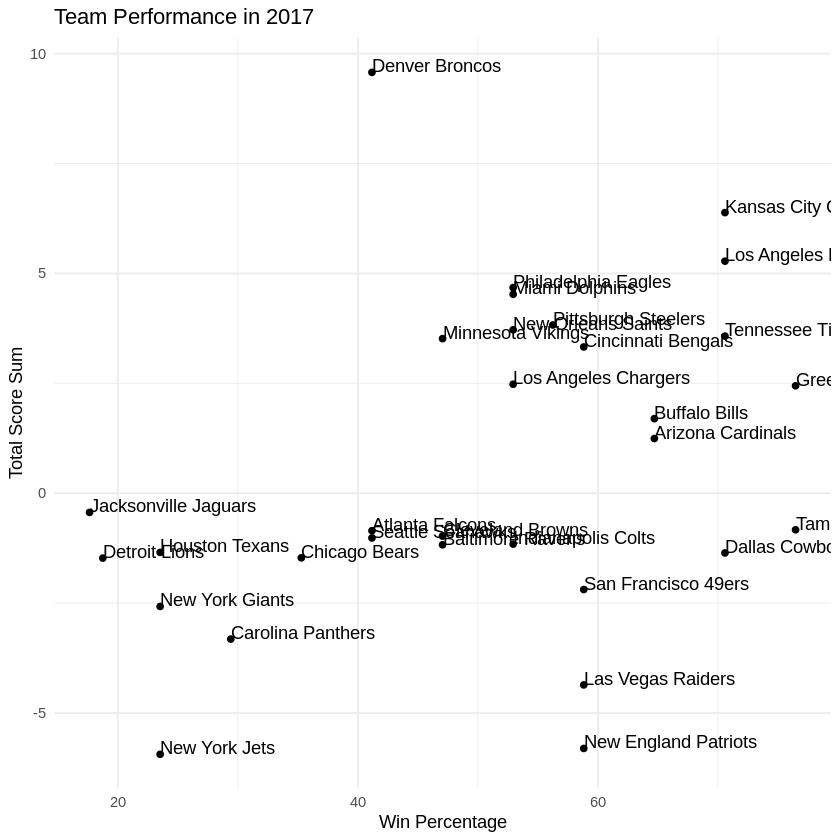

In [20]:
library(ggplot2)



# Create a dot plot of WinPCT and Sentiment
ggplot(subset_df_2017, aes(x = win_percentage, y = total_score_sum, label = Team)) +
  geom_point() +
  geom_text(hjust = 0, vjust = 0) +
  labs(x = "Win Percentage", y = "Total Score Sum", title = "Team Performance in 2017") +
  theme_minimal()

In [21]:

write.csv(subset_df_2017, "winpct_sentiment_score_2021.csv", row.names = FALSE)
